In [8]:
# import all we need
from matplotlib import image
from matplotlib import pyplot
import time
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import pandas as pd 
import cv2
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

In [9]:
# set up dir of data
base_dir = '../plant-seedlings-classification/data'
train_dir = os.path.join(base_dir, 'train_g')
val_dir = os.path.join(base_dir, 'val_g')
# the 12 species
classes = os.listdir(train_dir)
# parameter
batch_size = 32
IMG_SHAPE = 150

In [10]:
#read training set
for dirname, _, filenames in os.walk(train_dir):
    for filename in filenames:
        os.path.join(dirname, filename)

DATADIR = train_dir
classes = os.listdir(train_dir)
IMG_SIZE= IMG_SHAPE
CATEGORIES = classes

training_data=[]
def create_training_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()
X=[]
y=[]

for categories, label in training_data:
    y.append(label)
    X.append(categories)

In [11]:
#read val set
for dirname, _, filenames in os.walk(val_dir):
    for filename in filenames:
        os.path.join(dirname, filename)

DATADIR = val_dir
classes = os.listdir(val_dir)
IMG_SIZE= IMG_SHAPE
CATEGORIES = classes

val_data=[]
def create_val_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                val_data.append([new_array,class_num])
            except Exception as e:
                pass
create_val_data()
X_val=[]
y_val=[]

for categories, label in val_data:
    y_val.append(label)
    X_val.append(categories)


In [12]:
X=np.array(X)
y=np.array(y)
X_val=np.array(X_val)
y_val=np.array(y_val)

In [13]:
#over_sample the training set
ReX_train = X.reshape(3801, 150 * 150 * 3)
X_resampled, y_resampled = SMOTE().fit_resample(ReX_train, y)

In [14]:
X_resampled = X_resampled.reshape(6276, 150 , 150 , 3)

In [15]:
X_resampled.shape

(6276, 150, 150, 3)

In [16]:
datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_resampled)
# fits the model on batches with real-time data augmentation:
train_data_gen = datagen.flow(X_resampled, 
                              y_resampled,
                              shuffle=True,
                              batch_size=batch_size)

In [17]:
image_gen_val = ImageDataGenerator(rescale=1./255)
image_gen_val.fit(X_val)
val_data_gen = image_gen_val.flow(X_val,
                                  y_val,
                                  batch_size=batch_size)

In [21]:
# model

model = Sequential()

model.add(Conv2D(16, (3,3), padding='same',strides=2, activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(12))

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

EPOCHS = 72
head_model = model
head_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 75, 75, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 9, 9, 64)        

In [23]:
history = head_model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_data_gen)

Epoch 1/72
197/197 [==============================] - 49s 241ms/step - loss: 2.1180 - accuracy: 0.2360 - val_loss: 1.7645 - val_accuracy: 0.4110
Epoch 2/72
197/197 [==============================] - 53s 270ms/step - loss: 1.8566 - accuracy: 0.3297 - val_loss: 1.6034 - val_accuracy: 0.4341
Epoch 3/72
197/197 [==============================] - 55s 277ms/step - loss: 1.7380 - accuracy: 0.3776 - val_loss: 1.4530 - val_accuracy: 0.4731
Epoch 4/72
197/197 [==============================] - 54s 274ms/step - loss: 1.6010 - accuracy: 0.4165 - val_loss: 1.3124 - val_accuracy: 0.5458
Epoch 5/72
197/197 [==============================] - 53s 267ms/step - loss: 1.4851 - accuracy: 0.4602 - val_loss: 1.2257 - val_accuracy: 0.5669
Epoch 6/72
197/197 [==============================] - 54s 273ms/step - loss: 1.4345 - accuracy: 0.4653 - val_loss: 1.1569 - val_accuracy: 0.5848
Epoch 7/72
197/197 [==============================] - 54s 275ms/step - loss: 1.3816 - accuracy: 0.4962 - val_loss: 1.0495 - val_ac

197/197 [==============================] - 50s 255ms/step - loss: 0.6635 - accuracy: 0.7559 - val_loss: 0.9067 - val_accuracy: 0.7050
Epoch 58/72
197/197 [==============================] - 50s 255ms/step - loss: 0.6645 - accuracy: 0.7591 - val_loss: 0.9369 - val_accuracy: 0.7050
Epoch 59/72
197/197 [==============================] - 50s 255ms/step - loss: 0.6535 - accuracy: 0.7656 - val_loss: 0.9878 - val_accuracy: 0.6934
Epoch 60/72
197/197 [==============================] - 50s 254ms/step - loss: 0.6481 - accuracy: 0.7670 - val_loss: 0.9162 - val_accuracy: 0.7144
Epoch 61/72
197/197 [==============================] - 51s 258ms/step - loss: 0.6282 - accuracy: 0.7720 - val_loss: 0.9907 - val_accuracy: 0.6965
Epoch 62/72
197/197 [==============================] - 50s 255ms/step - loss: 0.6472 - accuracy: 0.7680 - val_loss: 0.9043 - val_accuracy: 0.7018
Epoch 63/72
197/197 [==============================] - 50s 254ms/step - loss: 0.6489 - accuracy: 0.7645 - val_loss: 0.7824 - val_accurac

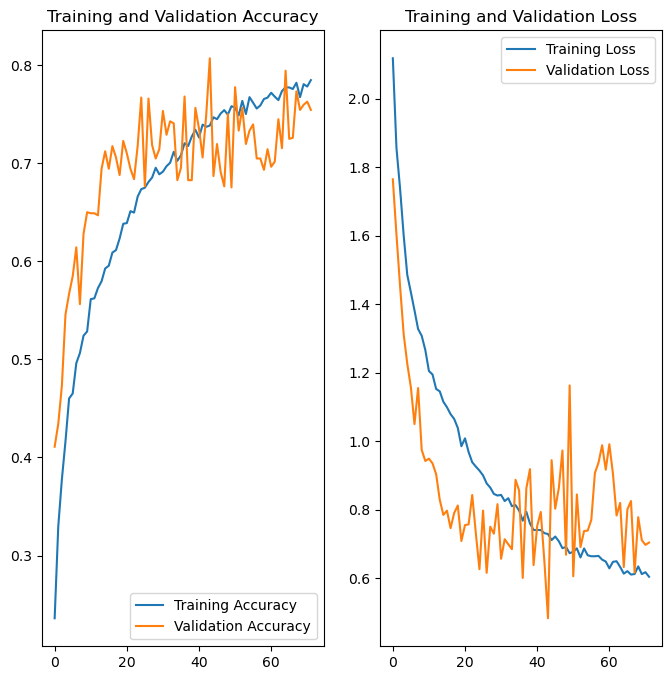

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
t = time.time()

export_path_keras = "./M4/{}.h5".format(int(t))
print(export_path_keras)

head_model.save(export_path_keras)

./M4/1672622021.h5


In [26]:
# reload
reloaded = tf.keras.models.load_model(
  './M4/1672622021.h5', 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

In [27]:
# predict the testdata
test_dir = '../plant-seedlings-classification/test'
testdata_dir = test_dir + '/testdata'
le = LabelEncoder()
le.fit(os.listdir(train_dir))
testdata = os.listdir(testdata_dir)
test_tal_num = 0
im = []
allimages= []
img_path = os.path.join(test_dir, 'testdata_b')
images = glob.glob(img_path + '/*.png')
allimages.extend(images)
#print("{}: {} Images".format(cl, len(images)))
test_tal_num += len(images)
#num_train = int(round(len(images)*0.8))
#train, val = images[:num_train], images[num_train:]
for i in range(len(images)):
    img = cv2.imread(allimages[i])
    img = tf.image.resize(img, [150,150])
    im.append(img)
im = np.array(im)/255.0
predictions = reloaded.predict(im)

25/25 [==============================] - 1s 20ms/step


In [28]:
results = []
for i in range(predictions.shape[0]):
    results.append(np.argmax(predictions[i]))
PredStr = list(le.inverse_transform(results))
result = {'file':testdata,'species':PredStr}
result = pd.DataFrame(result)
result.to_csv("Prediction_M4.csv",index=False)
#score : 0.78

30/30 [==============================] - 1s 23ms/step


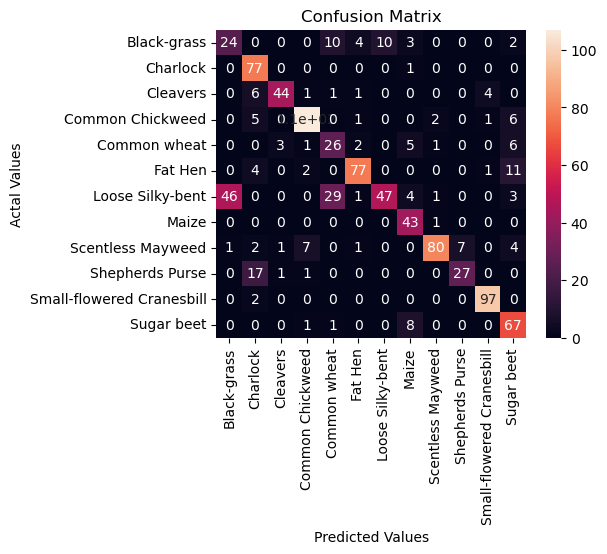

In [29]:
# confution matrix
X_val = X_val/255
prediction_val = reloaded.predict(X_val)
results_val = []
for i in range(prediction_val.shape[0]):
    results_val.append(np.argmax(prediction_val[i]))
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_val, results_val)
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()